<a href="https://colab.research.google.com/github/Morfinic/PWR_1_st.2_UM/blob/master/P2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image as pimg
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras import regularizers, Sequential
from IPython.display import Image

Poniższy blok pobiera dataset z Kaggle. Po uruchomieniu możliwe jest wybranie pliku, który posłuży jako klucz dostępu (Konto Kaggle -> Ustawienia -> API/Create new token).

**Datasets**
* https://www.kaggle.com/datasets/birdy654/cifake-real-and-ai-generated-synthetic-images
* https://www.kaggle.com/datasets/cashbowman/ai-generated-images-vs-real-images


In [2]:
from google.colab import files
%cd /content
files.upload()

kaggle_path = "cashbowman/ai-generated-images-vs-real-images"

!rm -r ~/.kaggle
!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d $kaggle_path

import zipfile
zip_ref = zipfile.ZipFile(kaggle_path.split('/')[-1] + '.zip', 'r')
zip_ref.extractall('/content/kaggle')
zip_ref.close()

/content


Saving kaggle.json to kaggle.json
rm: cannot remove '/root/.kaggle': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/cashbowman/ai-generated-images-vs-real-images
License(s): Community Data License Agreement - Sharing - Version 1.0


In [3]:
print("Devices: ", tf.config.list_physical_devices())

Devices:  [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [24]:
datasetPath = "/content/kaggle"

imgDim = (350, 350)
batchSize = 4

dataset = tf.keras.utils.image_dataset_from_directory(
    datasetPath,
    label_mode='binary',
    seed=500,
    image_size=imgDim,
    batch_size=batchSize,
    shuffle=True
)

trainingSetSize = 0.8
validationgSetSize = 0.1

datasetSize = len(dataset)
trainBatches = int(datasetSize * trainingSetSize) + 1
validationBatches = int(datasetSize * validationgSetSize)
testingBatches = datasetSize - trainBatches - validationBatches

trainingSet = dataset.take(trainBatches)
validationSet = dataset.skip(trainBatches).take(validationBatches)
testingSet = dataset.skip(trainBatches + validationBatches)

trainingSet = trainingSet.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
validationSet = validationSet.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
testingSet = testingSet.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

print("Training set lenght:", len(trainingSet))
print("Validation set lenght:", len(validationSet))
print("Testing set lenght:", len(testingSet))
print("Training classes: ", dataset.class_names)



Found 971 files belonging to 2 classes.
Training set lenght: 195
Validation set lenght: 24
Testing set lenght: 24
Training classes:  ['AiArtData', 'RealArt']


In [6]:
def plotMetrics(history, metric):
    plt.plot(history.history[metric], label = metric)
    plt.plot(history.history['val_' + metric], label='val_' + metric)
    plt.xlabel('Epochs')
    plt.ylabel(metric)
    plt.legend()
    plt.show()

classNames = ['FAKE', 'REAL']
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 10, restore_best_weights = True)

---
# VGG16
---

In [25]:
VGG16_base = tf.keras.applications.VGG16(
    include_top=False,
    weights="imagenet",
    input_shape=(*imgDim, 3),
    pooling="avg"
)

VGG16_base.trainable = False

input = tf.keras.Input(shape=(*imgDim, 3))

data_aug = Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomContrast(0.1),
    tf.keras.layers.RandomBrightness(0.1)
])

x = data_aug(input)

x = VGG16_base(x, training=False)
x = tf.keras.layers.Flatten()(x)
x = BatchNormalization(
    axis=-1,
    momentum=0.99,
    epsilon=0.001,
    center=True,
    scale=True
)(x)
x = Dense(
    256,
    activation="relu",
    kernel_regularizer=regularizers.l2(0.001),
    bias_regularizer=regularizers.l2(0.001),
    activity_regularizer=regularizers.l1(0.001)
)(x)
x = Dense(
    128,
    activation="relu"
)(x)
x = Dropout(
    rate = .5,
    seed = 500
)(x)
x = Dense(
    64,
    activation="relu"
)(x)
output = Dense(1, activation="sigmoid")(x)

VGG16_model = tf.keras.Model(input, output)

VGG16_model.compile(
    optimizer = tf.keras.optimizers.Adamax(learning_rate = .001),
    loss = tf.keras.losses.BinaryCrossentropy(),
    metrics = ['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

VGG16_model.summary()


Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 350, 350, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_2 (Sequential)       │ (None, 350, 350, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 512)            │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,889,281 (56.80 MB)

 Trainable params: 173,569 (678.00 KB)

 Non-trainable params: 14,715,712 (56.14 MB)

In [26]:
print("Starting training at", datetime.now())
VGG16_history = VGG16_model.fit(
    trainingSet,
    validation_data = validationSet,
    epochs = 100,
    verbose = 1,
    callbacks = [early_stopping]
)
print("Finished trainging at", datetime.now())
VGG16_model.save("VGG16-1-gen.keras")
print("Saved trained model")

Starting training at 2025-04-27 12:13:46.749335
Epoch 1/100
195/195 ━━━━━━━━━━━━━━━━━━━━ 34s 149ms/step - accuracy: 0.6169 - loss: 1.4909 - precision_2: 0.5634 - recall_2: 0.5876 - val_accuracy: 0.6146 - val_loss: 1.8257 - val_precision_2: 0.7895 - val_recall_2: 0.3125
Epoch 2/100
195/195 ━━━━━━━━━━━━━━━━━━━━ 16s 82ms/step - accuracy: 0.7036 - loss: 1.3168 - precision_2: 0.6708 - recall_2: 0.6246 - val_accuracy: 0.6667 - val_loss: 1.6135 - val_precision_2: 0.7667 - val_recall_2: 0.4792
Epoch 3/100
195/195 ━━━━━━━━━━━━━━━━━━━━ 19s 75ms/step - accuracy: 0.7219 - loss: 1.2450 - precision_2: 0.6803 - recall_2: 0.6824 - val_accuracy: 0.7083 - val_loss: 1.5571 - val_precision_2: 0.8125 - val_recall_2: 0.5417
Epoch 4/100
195/195 ━━━━━━━━━━━━━━━━━━━━ 21s 76ms/step - accuracy: 0.7588 - loss: 1.1768 - precision_2: 0.7310 - recall_2: 0.7060 - val_accuracy: 0.7500 - val_loss: 1.5085 - val_precision_2: 0.8333 - val_recall_2: 0.6250
Epoch 5/100
195/195 ━━━━━━━━━━━━━━━━━━━━ 15s 77ms/step - accuracy: 

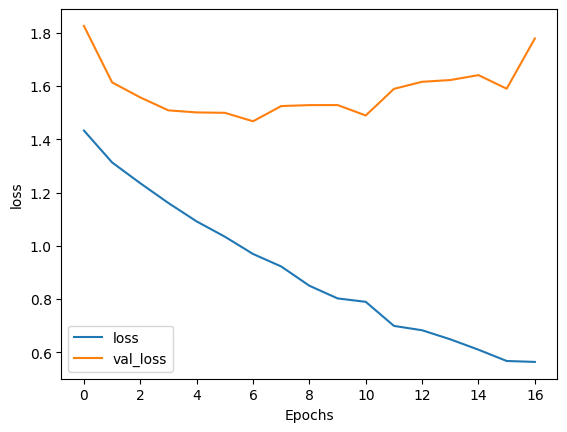

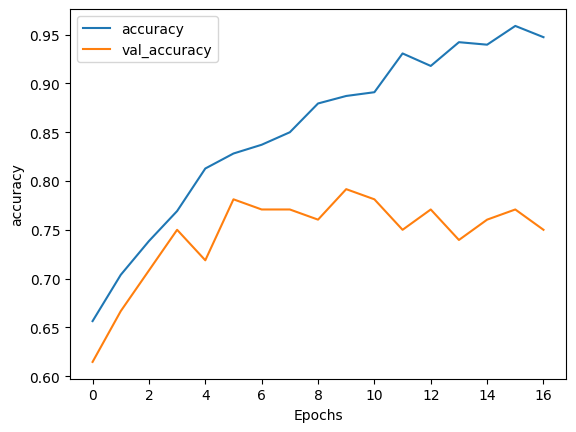

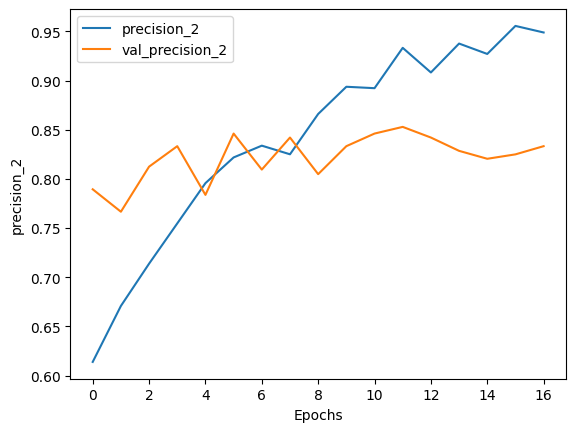

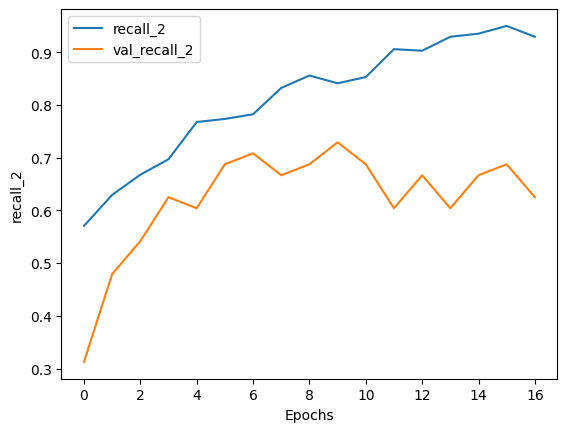

In [28]:
plotMetrics(VGG16_history, "loss")
plotMetrics(VGG16_history, "accuracy")
plotMetrics(VGG16_history, "precision")
plotMetrics(VGG16_history, "recall")

---
# Testing
---

In [32]:
%cd /content
loadedModel = tf.keras.models.load_model("VGG16-1-gen.keras")

/content


In [31]:
val_loss, val_accuracy, val_precision, val_recall = loadedModel.evaluate(testingSet)

print(f"Loss: {val_loss:.4f}")
print(f"Accuracy: {val_accuracy:.4f}")
print(f"Precision: {val_precision:.4f}")
print(f"Recall: {val_recall:.4f}")

ValueError: Input 0 of layer "functional_3" is incompatible with the layer: expected shape=(None, 500, 500, 3), found shape=(None, 350, 350, 3)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


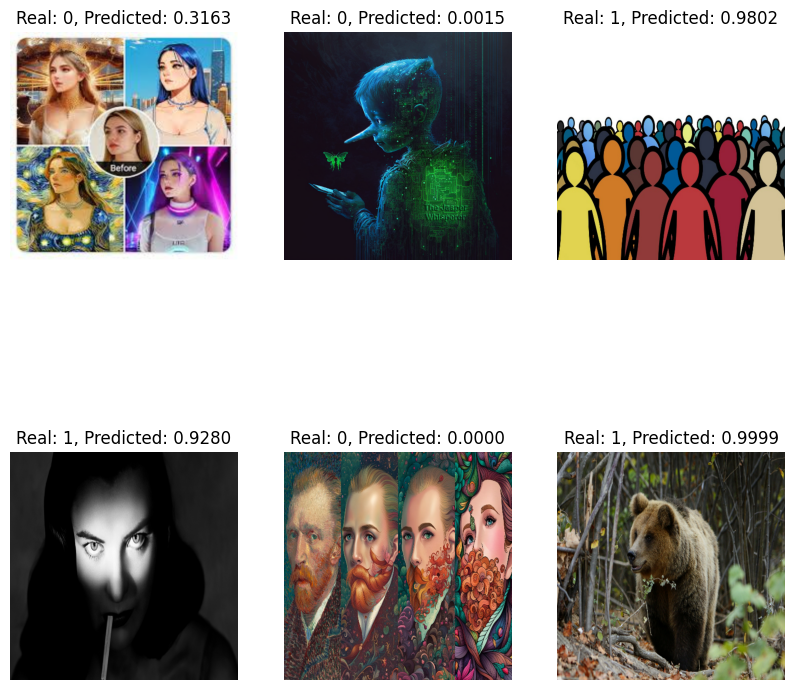

In [17]:
plt.figure(figsize=(10, 10))
for images, labels in trainingSet.take(1):
    for i in range(6):
        ax = plt.subplot(2, 3, i + 1)
        plt.imshow(np.array(images[i]).astype("uint8"))
        result = loadedModel.predict(np.expand_dims(np.array(images[i]), axis = 0))
        plt.title(f"Real: {int(labels[i])}, Predicted: {result[0 ,0]:.4f}")
        plt.axis("off")

mkdir: cannot create directory ‘/content/imgTest’: File exists
/content/imgTest


Saving comment_tDyavrQaKKtLQQ2XZfFNwU7Gblne5bMX.jpg to comment_tDyavrQaKKtLQQ2XZfFNwU7Gblne5bMX.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


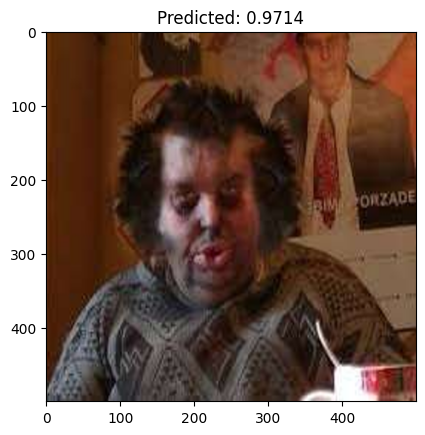

In [23]:
!mkdir /content/imgTest
%cd /content/imgTest
uploaded = files.upload()
uploadName = list(uploaded.keys())[0]

with pimg.open(uploadName) as img:
  res = img.resize(imgDim).convert('RGB')
  result = loadedModel.predict(np.expand_dims(np.array(res), axis = 0))
  plt.title(f"Predicted: {result[0 ,0]:.4f}")
  imgplot = plt.imshow(res)
  plt.show()